In [6]:
# need to do this before transformer imports
import os
#os.environ['HF_HOME'] = '/workspace/cache/huggingface/'

import os
os.chdir('/workspace/FutureGPT2/src')
from models.utils import *
from models.bigram_model import *
from models.mlp_model import *
from models.myopic_model import *
from data.utils import get_tokenizer, MODEL_NAME_DICT
import datasets
import torch
from torch.utils.data import DataLoader
from torch import nn
from itertools import islice
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from datasets import Dataset

from tqdm import tqdm
import pandas as pd
import gc
from glob import glob
import numpy as np
import copy
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
model = LitMyopicModel.load_from_checkpoint('/workspace/checkpoints/GPT2-MYOPIC-val_kl_loss-0.247.ckpt', strict=False).to('cuda')

SHRINK_MLP: 51230976 trainable / 79579392 total (0.6437718951157606)


In [89]:
orig, myopic = model.orig_model, model.myopic_model

In [9]:
bigram = LitPseudoBigram.load_from_checkpoint('/workspace/checkpoints/GPT2_BIGRAM_val_loss=5.74.ckpt').to('cuda')

In [10]:
dataset = datasets.load_from_disk('/workspace/corpus/msmarco/msmarco_GPT2_64tokens_1m').with_format('torch', device='cuda')
loaders = {
    split: DataLoader(dataset[split], batch_size=128)
    for split in ['train', 'val', 'test']
}

In [12]:
torch.set_grad_enabled(False)

In [14]:
loss = 0
ce = nn.CrossEntropyLoss()
for batch in tqdm(islice(iter(loaders['test']), 100), total=100):
    out = bigram(batch)
    loss += ce(
        out.view(-1, out.shape[-1])[:-1,:],
        batch['input_ids'].view(-1)[1:],
    ).item()
    gc.collect()
    torch.cuda.empty_cache()
loss / 100

100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


5.8662174034118655

In [90]:
offset_orig = copy.deepcopy(orig)

In [113]:
batches = 100
test_iter = islice(iter(loaders['test']), batches)
model_surps = []
model_confs = []
bigram_surps = []
bigram_confs = []
diff_norms = []
self_attns = []
prev_attns = []
futr_attns = []
myopic_surps = []
myopic_confs = []
myopic_kls = []
offset_kls = []
idxs = []
for batch in tqdm(test_iter, total=batches):
    '''
    diff_norm: sum of norm of between-layer differences per token
    bigram_surp: bigram loss against label
    bigram_conf: bigram output distribution entropy
    model_surp: model loss against label
    model_conf: model output entropy
    self_attn: token attn weight for self, avg across heads and layers
    futr_attn: avg of other token's attn weight against this one, avg across heads and layers
    prev_attn: avg of this token's attn weight against others, avg across heads and layers
    idx: index in sequence
    
    Throw out first token (b/c attn weights are abnormally high)
    and last token (b/c we don't have loss for last)
    '''
    out = orig(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        labels=batch['input_ids'],
        output_hidden_states=True,
        output_attentions=True,
    )
    h = torch.stack(out.hidden_states)
    diff = torch.diff(
        h, n=1, dim=0, 
        prepend=torch.zeros(out.hidden_states[0].shape).unsqueeze(0).to('cuda')
    )
    diff_norm = diff.norm(dim=3).sum(dim=0)[:,1:-1]
    diff_norms.append(diff_norm)
    model_conf = nn.CrossEntropyLoss(reduction='none')(
        out.logits.transpose(1, 2)[:,:,1:-1],
        torch.softmax(out.logits, dim=2).transpose(1, 2)[:,:,1:-1]
    )
    model_surp = nn.CrossEntropyLoss(reduction='none')(
        out.logits.transpose(1, 2)[:,:,1:-1],
        batch['input_ids'][:,2:],
    )
    bigram_out = bigram(batch)
    bigram_conf = nn.CrossEntropyLoss(reduction='none')(
        bigram_out.transpose(1, 2)[:,:,1:-1],
        torch.softmax(bigram_out, dim=2).transpose(1, 2)[:,:,1:-1]
    )
    bigram_surp = nn.CrossEntropyLoss(reduction='none')(
        bigram_out.transpose(1, 2)[:,:,1:-1],
        batch['input_ids'][:,2:]
    )
    attn = out.attentions
    # cut first and last from attn
    #attn = [x[:,:,1:-1,1:-1] for x in attn]
    self_attn = sum([x.diagonal(dim1=2, dim2=3).mean(dim=1) for x in attn])[:,1:-1] / len(attn)
    idx_desc = torch.range(attn[0].shape[-1]-1, 0, -1).to('cuda')
    idx_asc = torch.range(0, attn[0].shape[-1]-1).to('cuda')
    # this is tricky -- avg is over lower triangle
    futr_attn = sum([
        ((x.sum(dim=2) - x.diagonal(dim1=2, dim2=3)) / idx_desc).mean(dim=1) for x in attn
    ])[:,1:-1] / len(attn)
    prev_attn = sum([
        ((x.sum(dim=3) - x.diagonal(dim1=2, dim2=3)) / idx_asc).mean(dim=1) for x in attn
    ])[:,1:-1] / len(attn)

    myopic = to_myopic_gpt2(myopic, out.past_key_values)
    myopic_out = myopic(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        labels=batch['input_ids'],
        #output_hidden_states=True,
        #output_attentions=True,
    )
    myopic_conf = nn.CrossEntropyLoss(reduction='none')(
        myopic_out.logits.transpose(1, 2)[:,:,1:-1],
        torch.softmax(out.logits, dim=2).transpose(1, 2)[:,:,1:-1]
    )
    myopic_surp = nn.CrossEntropyLoss(reduction='none')(
        myopic_out.logits.transpose(1, 2)[:,:,1:-1],
        batch['input_ids'][:,2:],
    )
    myopic_kl = nn.KLDivLoss(reduction='none', log_target=True)(
        torch.log_softmax(myopic_out.logits.transpose(1, 2)[:,:,1:-1], dim=1),
        torch.log_softmax(out.logits.transpose(1, 2)[:,:,1:-1], dim=1),
    ).sum(axis=1)

    # offset_orig is orig but getting attns from myopic on token t-1.
    offset_orig = to_myopic_gpt2(offset_orig, myopic_out.past_key_values, offset=-1, reverse=True)
    offset_out = offset_orig(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        labels=batch['input_ids']
    )
    # shift by one for comparison, so [2:] instead of [1:-1]
    offset_kl = nn.KLDivLoss(reduction='none', log_target=True)(
        torch.log_softmax(offset_out.logits.transpose(1, 2)[:,:,2:], dim=1),
        torch.log_softmax(out.logits.transpose(1, 2)[:,:,2:], dim=1),
    ).sum(axis=1)
    
    bigram_surps.append(bigram_surp)
    bigram_confs.append(bigram_conf)
    model_surps.append(model_surp)
    model_confs.append(model_conf)
    self_attns.append(self_attn)
    futr_attns.append(futr_attn)
    prev_attns.append(prev_attn)
    myopic_surps.append(myopic_surp)
    myopic_confs.append(myopic_conf)
    myopic_kls.append(myopic_kl)
    offset_kls.append(offset_kl)
    idxs.append(idx_asc[1:-1].broadcast_to(prev_attn.shape))
    

100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


In [121]:
stats = torch.stack(
    [
        torch.concat([a.flatten() for a in x], dim=0)
        for x in [
            #idxs, 
            #diff_norms, 
            self_attns, 
            #prev_attns,
            #futr_attns,
            bigram_confs, 
            bigram_surps, 
            model_confs, 
            model_surps, 
            #myopic_confs,
            #myopic_surps,
            myopic_kls,
            offset_kls,
        ]
    ],
    dim=1
)

In [122]:
stats = stats.cpu().numpy()

In [123]:
names = [
    #'idx', 
    #'diff_norm', 
    'self_attn', 
    #'prev_attn',
    #'futr_attn',
    'bigram_conf', 
    'bigram_surp', 
    'model_conf', 
    'model_surp', 
    #'myopic_conf',
    #'myopic_surp',
    'myopic_kl',
    'offset_kl',
]

In [124]:
for name, mean in zip(names, stats.mean(axis=0)):
    print(name, mean)

self_attn 0.07824151
bigram_conf 5.7783637
bigram_surp 5.737952
model_conf 3.675084
model_surp 3.637462
myopic_kl 0.24979144
offset_kl 1.2678878


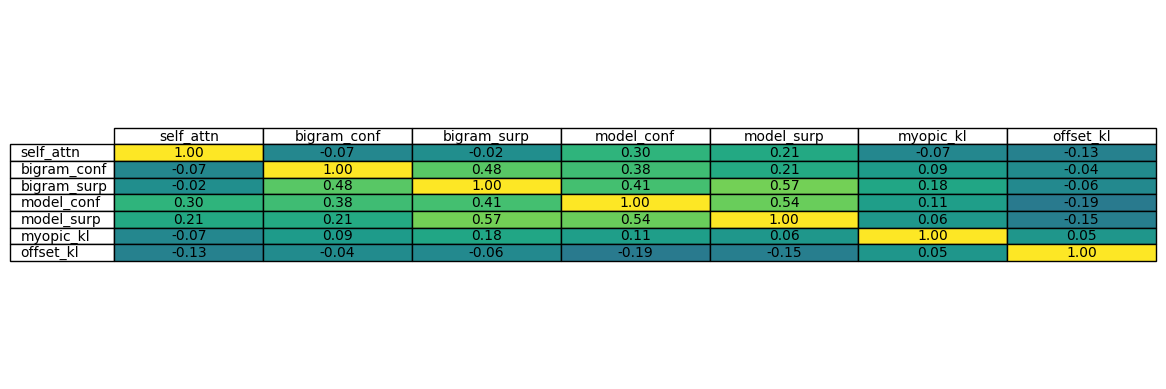

In [126]:
corr = np.corrcoef(stats.T)
corr_str = np.vectorize(lambda x: f'{x:.2f}')(corr)

fig, ax = plt.subplots()
table = ax.table(
    cellText=corr_str, 
    loc='center', 
    cellLoc='center', 
    colWidths=[0.3 for _ in range(len(corr))],
    colLabels=names,
    rowLabels=names,
)

for i in range(len(corr)):
    for j in range(len(corr[0])):
        color = plt.cm.viridis((1 + corr[i][j]) / 2)
        table[(i+1, j)].set_facecolor(color)
ax.axis('off')
plt.show()

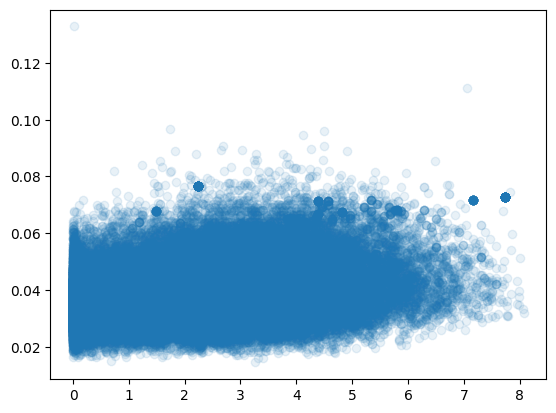

In [92]:
plt.scatter(stats[:,4], stats[:,6], alpha=0.1)
plt.show()

In [154]:
from scipy.stats import pearsonr
pearsonr(stats[:,1], stats[:,4])

PearsonRResult(statistic=0.08322467017503568, pvalue=6.65505084073087e-124)

In [155]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm()
  

In [160]:
model.model.embed_tokens.embedding_dim

4096

In [171]:
for i in range(32):
    print(list(model.model.layers[i].post_attention_layernorm.parameters())[0].mean())

tensor(0.4160, device='cuda:0', dtype=torch.bfloat16)
tensor(0.6055, device='cuda:0', dtype=torch.bfloat16)
tensor(0.7734, device='cuda:0', dtype=torch.bfloat16)
tensor(0.9336, device='cuda:0', dtype=torch.bfloat16)
tensor(1.0156, device='cuda:0', dtype=torch.bfloat16)
tensor(1.1406, device='cuda:0', dtype=torch.bfloat16)
tensor(1.2266, device='cuda:0', dtype=torch.bfloat16)
tensor(1.3359, device='cuda:0', dtype=torch.bfloat16)
tensor(1.4062, device='cuda:0', dtype=torch.bfloat16)
tensor(1.4375, device='cuda:0', dtype=torch.bfloat16)
tensor(1.4609, device='cuda:0', dtype=torch.bfloat16)
tensor(1.5078, device='cuda:0', dtype=torch.bfloat16)
tensor(1.6172, device='cuda:0', dtype=torch.bfloat16)
tensor(1.7109, device='cuda:0', dtype=torch.bfloat16)
tensor(1.7812, device='cuda:0', dtype=torch.bfloat16)
tensor(1.9219, device='cuda:0', dtype=torch.bfloat16)
tensor(2.0938, device='cuda:0', dtype=torch.bfloat16)
tensor(2.2656, device='cuda:0', dtype=torch.bfloat16)
tensor(2.4062, device='cuda: